In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torchvision

from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

# Read data + augmentation

In [2]:
aug = torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(90)])

In [3]:
class_names = ['rock', 'paper', 'scissors']

def read_dataset(dirpath='../data/rockpaperscissors', n_aug=3):
    X, y = [], []

    for class_id, class_name in enumerate(class_names):
        for filename in os.listdir(f'{dirpath}/{class_name}'):
            original_image = Image.open(f'{dirpath}/{class_name}/{filename}')
            aug_images = [original_image] + [aug(original_image) for _ in range(n_aug)]

            for image in aug_images:
                X.append(image)
                y.append(class_id)

    permutation = np.random.permutation(len(y))
    return np.array(X, dtype=object)[permutation], np.array(y)[permutation]

In [4]:
X, y = read_dataset()

/tmp/ipykernel_12884/2347328683.py:16: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(X, dtype=object)[permutation], np.array(y)[permutation]


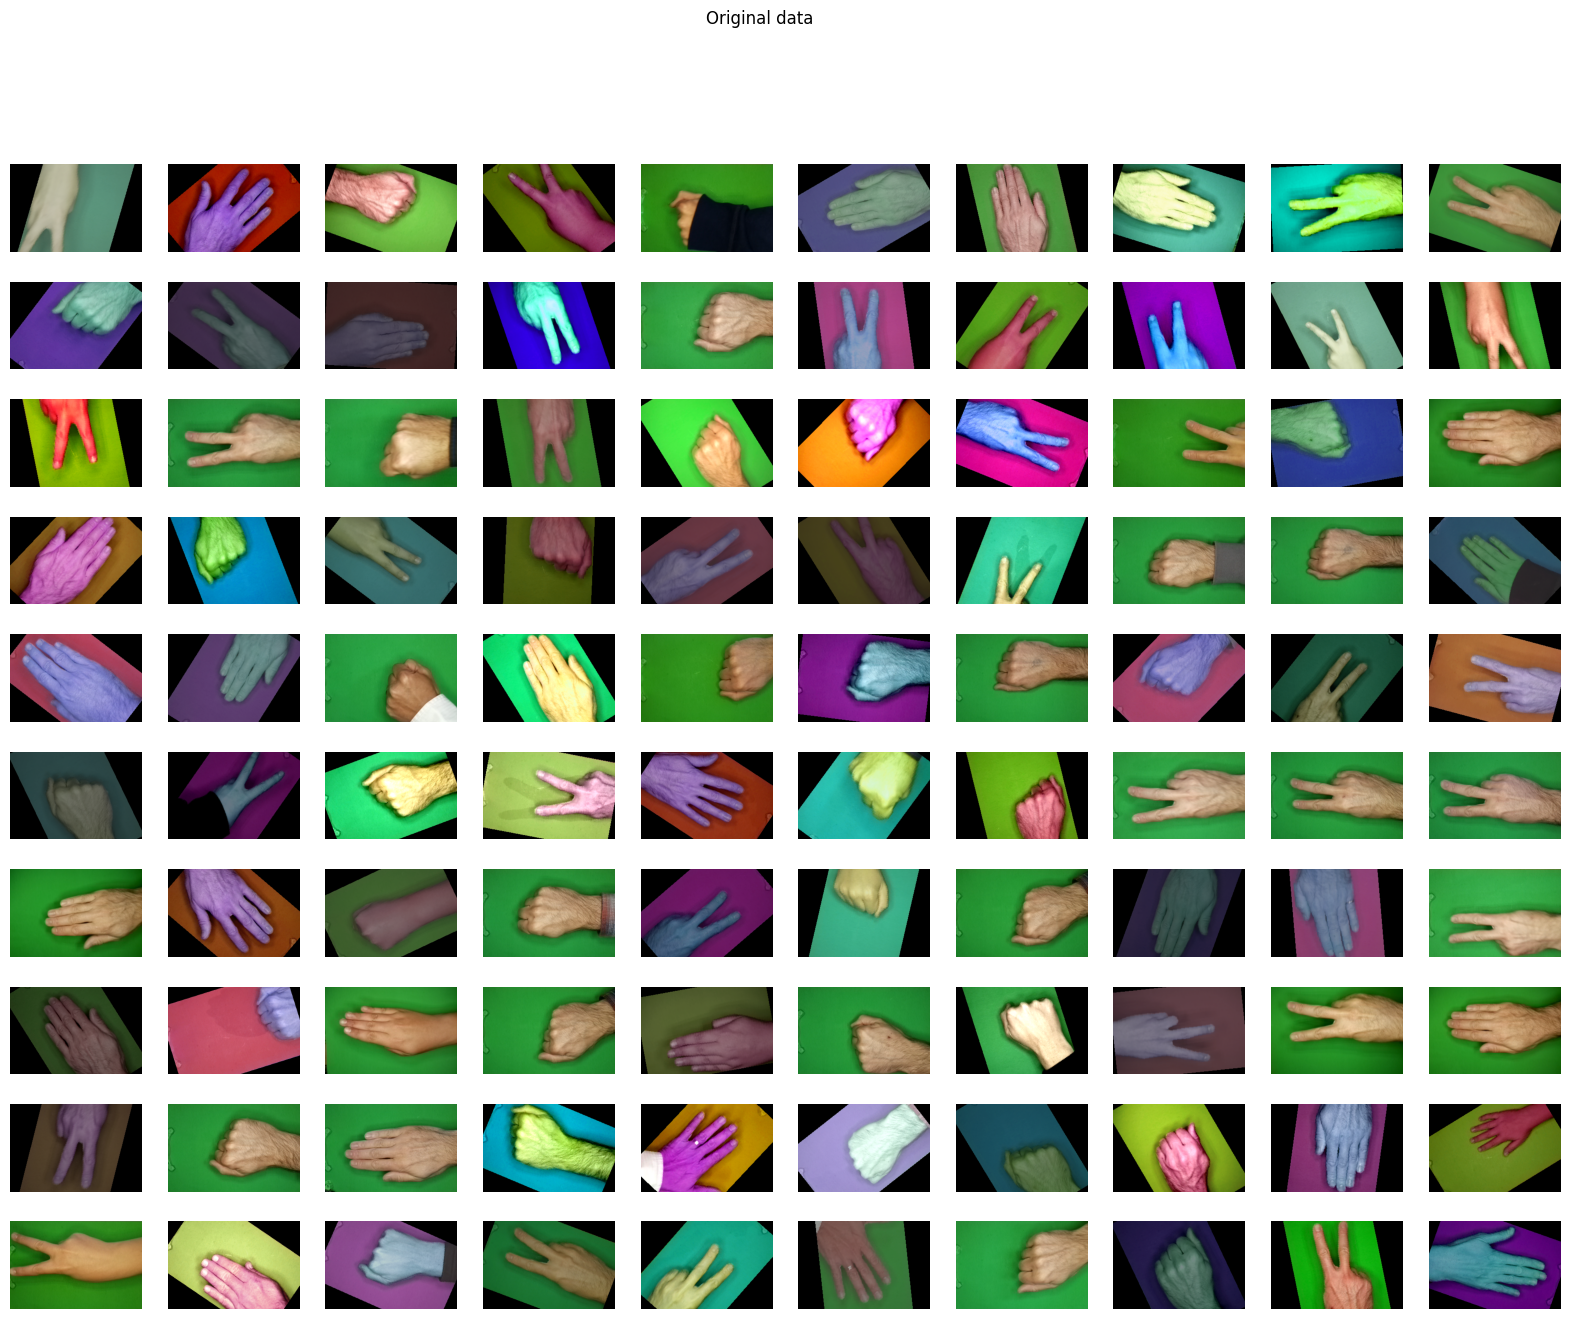

In [5]:
N, M = 10, 10
fig, ax = plt.subplots(N, M, figsize=(20, 15))
fig.suptitle('Original data')
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(X[np.random.choice(y.size)])
        ax[i,j].axis('off')
plt.show()

# Preprocessing

In [6]:
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v

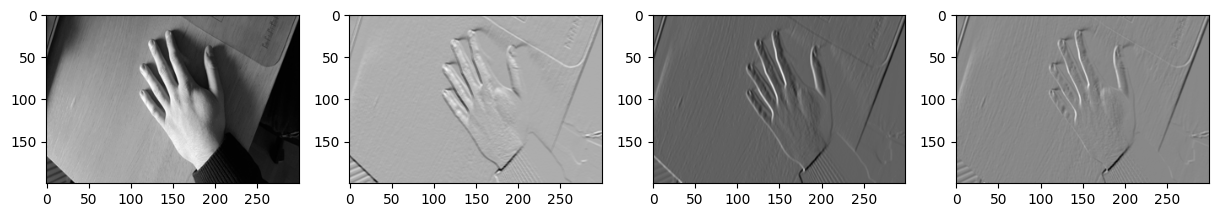

In [7]:
image = Image.open('../data/rockpaperscissors/custom-test-data/paper/20240114_121613.jpg')
image = np.array(image.resize((300, 200)).convert('L'))
edges_prewitt_horizontal = prewitt_h(image)
edges_prewitt_vertical = prewitt_v(image)
fig, ax = plt.subplots(1,4,figsize=(15,5))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(edges_prewitt_horizontal, cmap='gray')
ax[2].imshow(edges_prewitt_vertical, cmap='gray')
ax[3].imshow(edges_prewitt_vertical + edges_prewitt_horizontal, cmap='gray')
plt.show()

In [8]:
import skimage

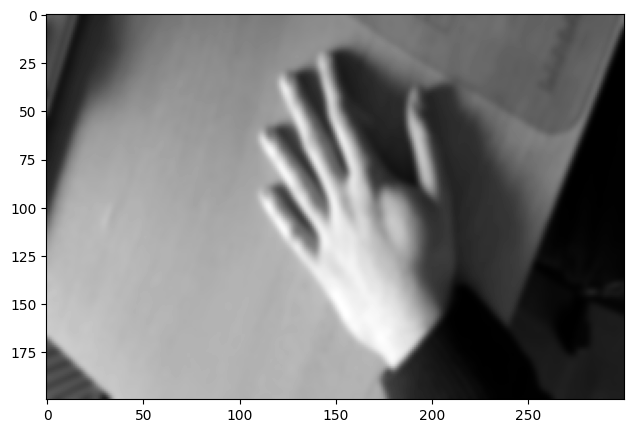

In [9]:
plt.imshow(skimage.filters.gaussian(image, sigma=1.5), cmap='gray')
plt.show()

In [10]:
def process_image(image):
    # image = np.array(image.resize((300, 200))).dot(np.array([65536, 256, 1]))
    # image = np.array(image.resize((300, 200)).convert('L'))
    # edges_prewitt_horizontal = prewitt_h(image)
    # edges_prewitt_vertical = prewitt_v(image)
    # return (edges_prewitt_vertical + edges_prewitt_horizontal).flatten()
    # return skimage.filters.gaussian(image, sigma=1.5).flatten()
    return np.array(image.resize((300, 200)).convert('L')).flatten()


def preprocess_dataset(X):
    X = np.array(list(map(process_image, X)))
    return X / X.mean(axis=1).reshape(-1,1)

In [11]:
X = preprocess_dataset(X)

In [12]:
TRAIN_SIZE = int(0.8 * y.shape[0])
X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]

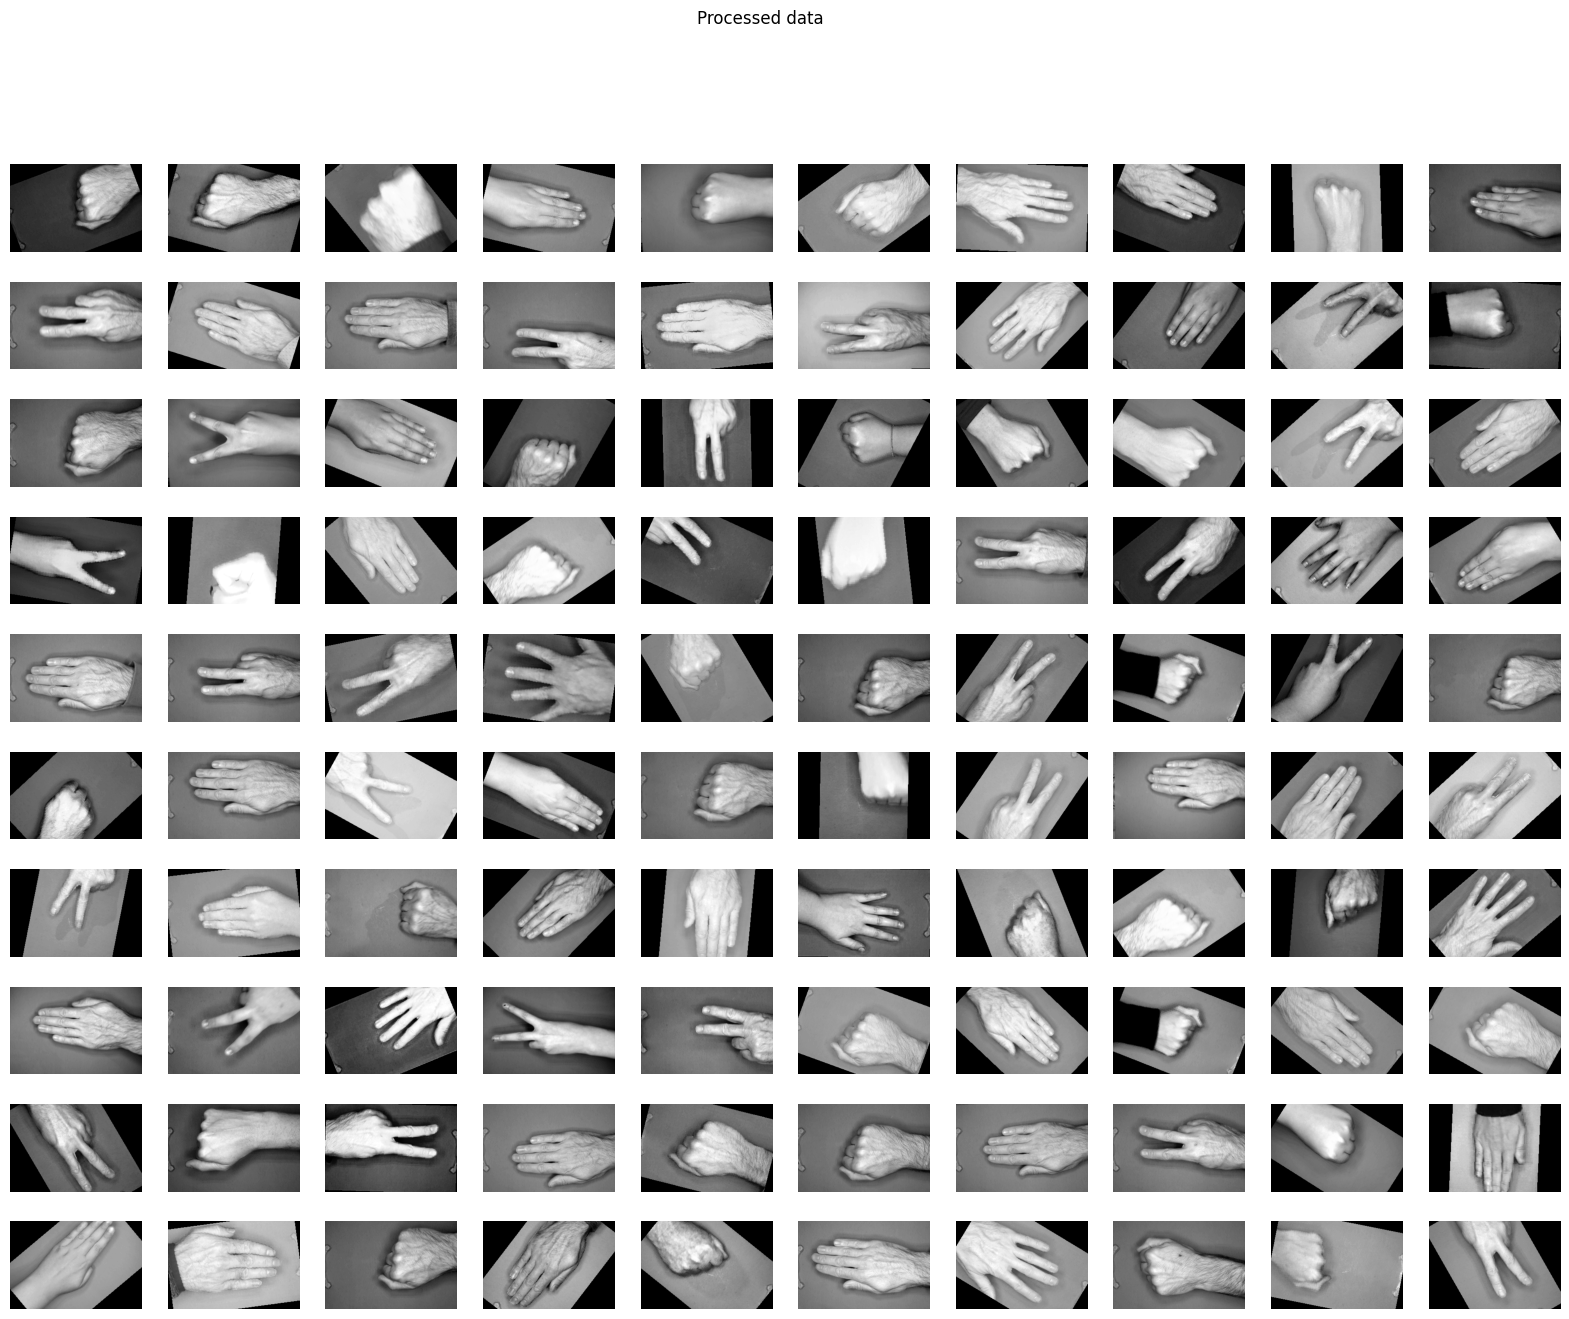

In [13]:
N, M = 10, 10
fig, ax = plt.subplots(N, M, figsize=(20, 15))
fig.suptitle('Processed data')
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(X[np.random.choice(y.size)].reshape(200, 300), cmap='gray')
        ax[i,j].axis('off')
plt.show()

# Feature extraction (dimension reduction)

### PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca_model = PCA(n_components=300)
X_pca = pca_model.fit_transform(X)

In [16]:
X_pca_train = X_pca[:TRAIN_SIZE]
X_pca_test = X_pca[TRAIN_SIZE:]

### CNN ???

# Classification

### Decision Tree Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier

##### Original data

In [18]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)
decision_tree_classifier.score(X_test, y_test)

0.43632210165619645

##### PCA transformed data

In [19]:
decision_tree_classifier_pca = DecisionTreeClassifier()
decision_tree_classifier_pca.fit(X_pca_train, y_train)
decision_tree_classifier_pca.score(X_pca_test, y_test)

0.4854368932038835

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

##### Original data

In [18]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
random_forest_classifier.fit(X_train, y_train)
random_forest_classifier.score(X_test, y_test)

0.8675042832667047

##### PCA tranformed data

In [19]:
random_forest_classifier_pca = RandomForestClassifier(n_estimators=100, n_jobs=-1)
random_forest_classifier_pca.fit(X_pca_train, y_train)
random_forest_classifier_pca.score(X_pca_test, y_test)

0.797829811536265

### Test saving model

In [23]:
import pickle

In [24]:
# save model
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(random_forest_classifier_pca, file)

In [25]:
# read model
with open('random_forest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [26]:
loaded_model.score(X_pca_test, y_test)

0.6070816676185037

### XGBoost

In [20]:
from xgboost import XGBClassifier

In [21]:
xgb = XGBClassifier(n_estimators=1000, max_depth=15)
xgb.fit(X_pca_train, y_train)
xgb.score(X_pca_test, y_test)

0.88692175899486

### Test on real data

In [22]:
X_real, y_real = read_dataset(dirpath='../data/rockpaperscissors/custom-test-data/', n_aug=0)

/tmp/ipykernel_12884/2347328683.py:16: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(X, dtype=object)[permutation], np.array(y)[permutation]


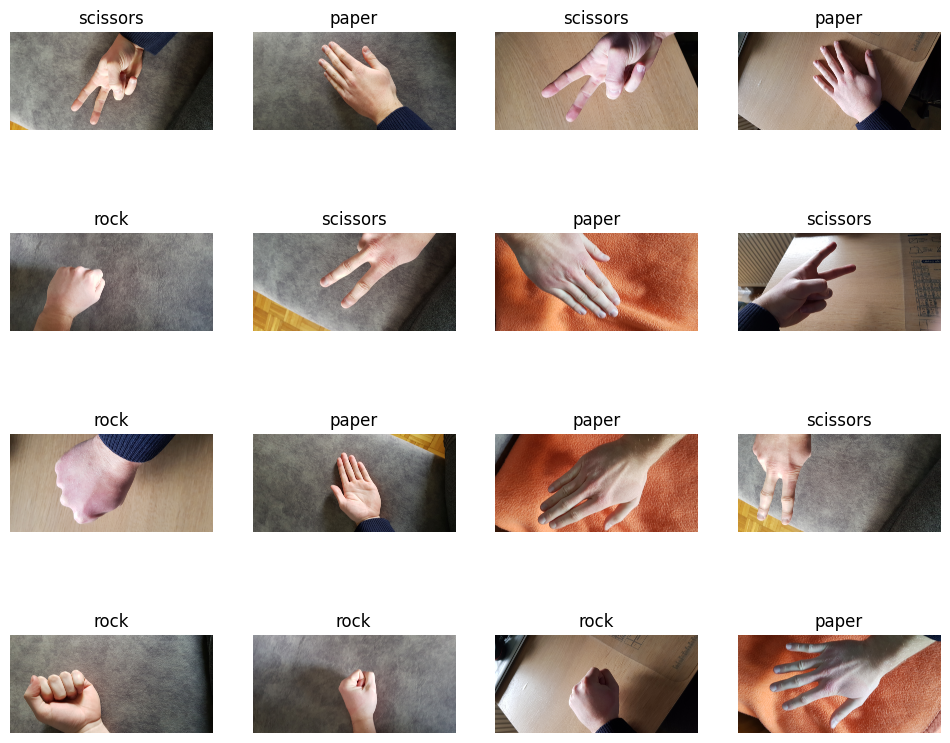

In [23]:
N, M = 4, 4
fig, ax = plt.subplots(N, M, figsize=(12,10))
for i in range(N):
    for j in range(M):
        ax[i, j].set_title(class_names[y_real[i*N + j]])
        ax[i, j].imshow(X_real[i*N + j])
        ax[i, j].axis('off')
plt.show()

In [24]:
X_real = preprocess_dataset(X_real)

In [25]:
def show_results(X, y, model, transform=lambda x: x):
    predictions = model.predict(transform(X))
    N, M = 4, 4
    fig, ax = plt.subplots(N, M, figsize=(12,10))
    for i in range(N):
        for j in range(M):
            ax[i, j].set_title(class_names[predictions[i*N + j]])
            ax[i, j].imshow(X_real[i*N + j].reshape((200,300)), cmap='gray')
            ax[i, j].axis('off')
    plt.show()
    print(f'Accuracy: {np.mean(predictions == y)}')

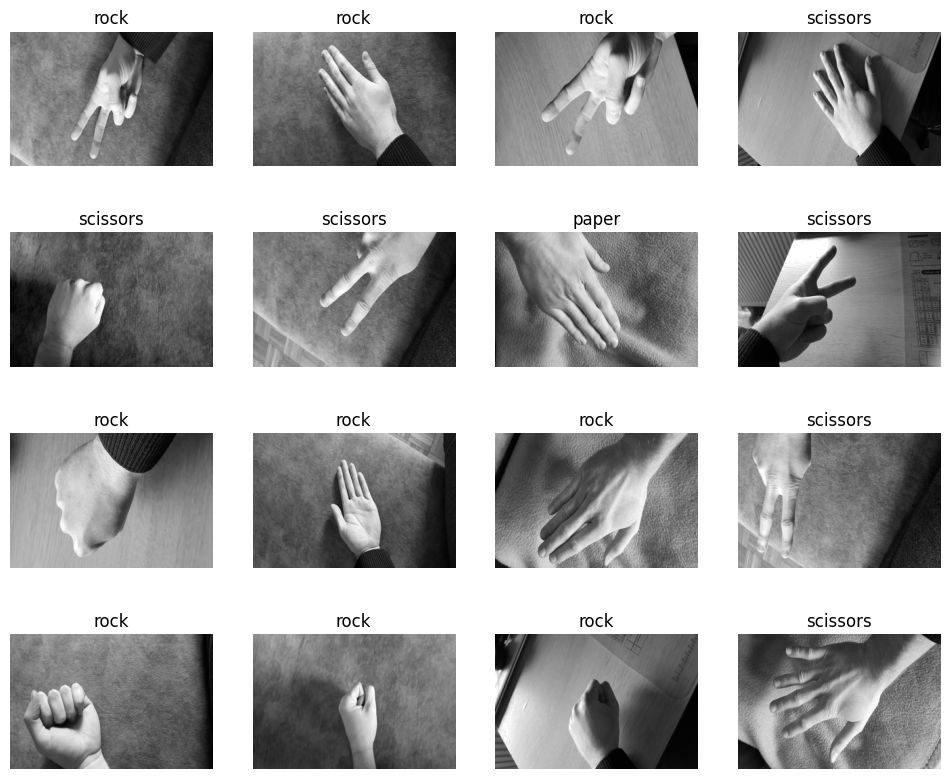

Accuracy: 0.5


In [26]:
show_results(X_real, y_real, random_forest_classifier)

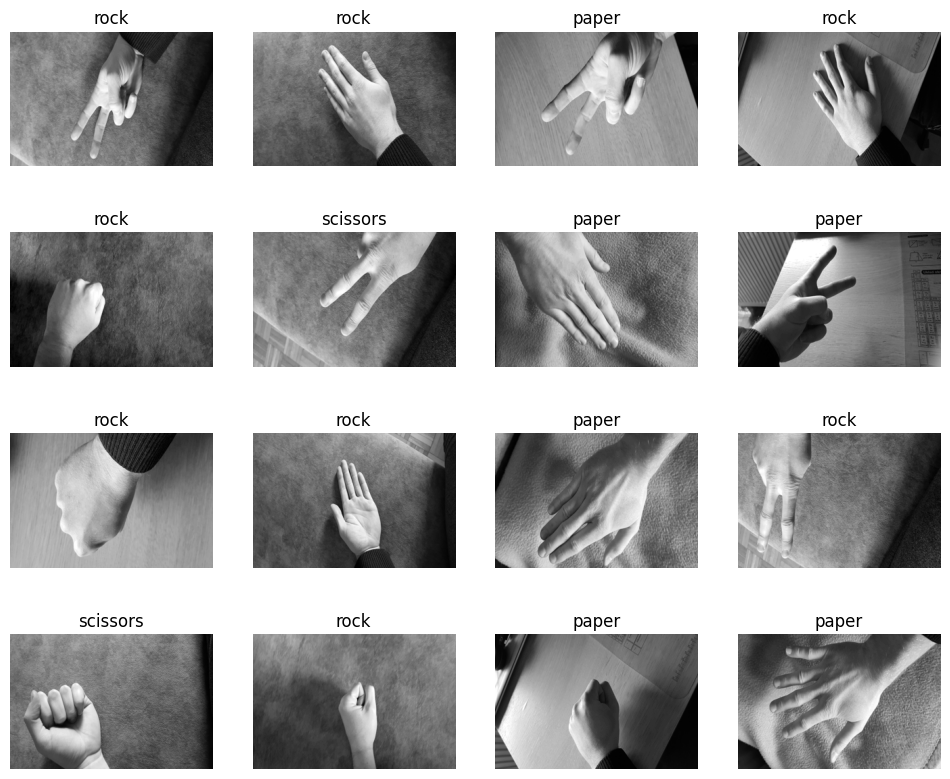

Accuracy: 0.4375


In [27]:
show_results(X_real, y_real, xgb, transform=lambda x: pca_model.transform(x))